In [1]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.0/227.0 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 11.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 10.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 9.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 10.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 11.6 MB/s eta 0:0

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers,models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from tqdm import tqdm

In [11]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 12.9 MB/s eta 0:00:0000:0100:01


In [12]:
import cv2

In [3]:
image_size = (224, 224)
num_classes = 2
epochs = 200

In [4]:
train_dir = '/Users/apple/Desktop/Pramod/group11/train'
validation_dir = '/Users/apple/Desktop/Pramod/group11/validation'
test_dir = '/Users/apple/Desktop/Pramod/group11/test'
batch_size = 64

In [36]:
def resize_image(image,target_size):
    resized_image = cv2.resize(image,target_size)
    return resized_image
def normalize_image(image):
    normalize_image = image/255.0
    return normalize_image
def reduce_noise(image):
    blurred_image = cv2.GaussianBlur(image,(3,3),0)
    return blurred_image
def equalized_histogram(image):
    image = cv2.convertScaleAbs(image)
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Perform histogram equalization
    equalized_image = cv2.equalizeHist(gray_image)
    return equalized_image


def preprocess(image):
    target_size = (224,224)
    image1 = resize_image(image,target_size)
    image2 = normalize_image(image1)
    image3 = reduce_noise(image2)
    #image4 = equalized_histogram(image3)
    return image3



datagen = ImageDataGenerator(
    preprocessing_function = preprocess,
    rotation_range=20,  # Random rotation by up to 20 degrees
    width_shift_range=0.2,  # Random horizontal shift by up to 20% of the width
    height_shift_range=0.2,  # Random vertical shift by up to 20% of the height
    shear_range=0.2,  # Shear angle in counter-clockwise direction in degrees
    zoom_range=0.2,  # Random zoom by up to 20%
    horizontal_flip=True,  # Random horizontal flipping
    vertical_flip=True,  # Random vertical flipping
    fill_mode='nearest'  # Fill mode for pixels outside the boundaries
)


train_flow = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_flow = datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)
test_flow = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 12049 images belonging to 2 classes.
Found 3552 images belonging to 2 classes.
Found 1839 images belonging to 2 classes.


In [6]:
train_flow.class_indices

{'fake': 0, 'real': 1}

In [7]:
from tensorflow.keras.models import Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification (fake vs real)

model = Model(inputs = base_model.input,outputs = predictions)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [8]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 42,406,977 (161.77 MB)

 Trainable params: 24,084,993 (91.88 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [9]:
optimizer = Adam(0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(
    train_flow,
    steps_per_epoch=20,
    epochs=200,
    validation_data=validation_flow,
    validation_steps=20
)

Epoch 1/200


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 160s 8s/step - accuracy: 0.5067 - loss: 7.4601 - val_accuracy: 0.7336 - val_loss: 0.5561
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 160s 8s/step - accuracy: 0.5542 - loss: 0.7571 - val_accuracy: 0.7180 - val_loss: 0.6298
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5507 - loss: 0.6886

2024-05-16 12:43:18.530315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 147s 8s/step - accuracy: 0.5512 - loss: 0.6885 - val_accuracy: 0.7540 - val_loss: 0.6035
Epoch 4/200


/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.5850 - loss: 0.6697 - val_accuracy: 0.8156 - val_loss: 0.5742
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 191s 10s/step - accuracy: 0.6162 - loss: 0.6569 - val_accuracy: 0.7672 - val_loss: 0.5287
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 174s 9s/step - accuracy: 0.6221 - loss: 0.6467 - val_accuracy: 0.8417 - val_loss: 0.4637
Epoch 7/200


2024-05-16 12:52:11.085109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 198s 10s/step - accuracy: 0.6328 - loss: 0.6333 - val_accuracy: 0.7828 - val_loss: 0.5240
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 197s 10s/step - accuracy: 0.6197 - loss: 0.6377 - val_accuracy: 0.8125 - val_loss: 0.4938
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 176s 9s/step - accuracy: 0.6582 - loss: 0.6286 - val_accuracy: 0.8185 - val_loss: 0.4512
Epoch 10/200


2024-05-16 13:01:42.372013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 9/20 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.6300 - loss: 0.6202

2024-05-16 13:02:27.221386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.6396 - loss: 0.6186 - val_accuracy: 0.8484 - val_loss: 0.4874
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 201s 10s/step - accuracy: 0.6684 - loss: 0.6125 - val_accuracy: 0.7758 - val_loss: 0.4811
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 170s 9s/step - accuracy: 0.6138 - loss: 0.6438 - val_accuracy: 0.8518 - val_loss: 0.4721
Epoch 13/200


2024-05-16 13:10:16.387533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 196s 10s/step - accuracy: 0.6512 - loss: 0.6147 - val_accuracy: 0.8477 - val_loss: 0.4339
Epoch 14/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 198s 10s/step - accuracy: 0.6406 - loss: 0.6234 - val_accuracy: 0.8633 - val_loss: 0.4370
Epoch 15/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 174s 9s/step - accuracy: 0.6602 - loss: 0.6283 - val_accuracy: 0.6956 - val_loss: 0.5287
Epoch 16/200


2024-05-16 13:19:44.624141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 199s 10s/step - accuracy: 0.6445 - loss: 0.6408 - val_accuracy: 0.8391 - val_loss: 0.4453
Epoch 17/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 191s 10s/step - accuracy: 0.6781 - loss: 0.5933 - val_accuracy: 0.7984 - val_loss: 0.5079
Epoch 18/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - accuracy: 0.6602 - loss: 0.6205 - val_accuracy: 0.8498 - val_loss: 0.4333
Epoch 19/200


2024-05-16 13:29:02.890735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 813s 43s/step - accuracy: 0.6555 - loss: 0.5946 - val_accuracy: 0.8195 - val_loss: 0.5132
Epoch 20/200
 9/20 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.6502 - loss: 0.6052

2024-05-16 13:43:08.623795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - accuracy: 0.6526 - loss: 0.6106 - val_accuracy: 0.8156 - val_loss: 0.4373
Epoch 21/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.7032 - loss: 0.5931 - val_accuracy: 0.8004 - val_loss: 0.4688
Epoch 22/200


2024-05-16 13:46:45.310907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 8s/step - accuracy: 0.6642 - loss: 0.5849 - val_accuracy: 0.8203 - val_loss: 0.4517
Epoch 23/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 178s 9s/step - accuracy: 0.6782 - loss: 0.6058 - val_accuracy: 0.7727 - val_loss: 0.4805
Epoch 24/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 165s 8s/step - accuracy: 0.6733 - loss: 0.6104 - val_accuracy: 0.7440 - val_loss: 0.4768
Epoch 25/200


2024-05-16 13:55:11.400299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 190s 10s/step - accuracy: 0.6646 - loss: 0.6045 - val_accuracy: 0.8055 - val_loss: 0.4488
Epoch 26/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 206s 11s/step - accuracy: 0.6327 - loss: 0.6080 - val_accuracy: 0.8523 - val_loss: 0.4142
Epoch 27/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 213s 11s/step - accuracy: 0.6545 - loss: 0.6022 - val_accuracy: 0.8095 - val_loss: 0.4570
Epoch 28/200


2024-05-16 14:05:19.930158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 237s 12s/step - accuracy: 0.6547 - loss: 0.5969 - val_accuracy: 0.7516 - val_loss: 0.4664
Epoch 29/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 219s 11s/step - accuracy: 0.6824 - loss: 0.5647 - val_accuracy: 0.7766 - val_loss: 0.4593
Epoch 30/200
 9/20 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - accuracy: 0.6470 - loss: 0.6083 

2024-05-16 14:13:44.012688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 129s 7s/step - accuracy: 0.6454 - loss: 0.6060 - val_accuracy: 0.8175 - val_loss: 0.4565
Epoch 31/200


2024-05-16 14:15:05.078999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 208s 11s/step - accuracy: 0.6846 - loss: 0.5718 - val_accuracy: 0.7945 - val_loss: 0.4388
Epoch 32/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 200s 10s/step - accuracy: 0.6545 - loss: 0.6121 - val_accuracy: 0.7937 - val_loss: 0.4475
Epoch 33/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 179s 9s/step - accuracy: 0.7061 - loss: 0.5763 - val_accuracy: 0.7450 - val_loss: 0.4899
Epoch 34/200


2024-05-16 14:24:52.432172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 189s 10s/step - accuracy: 0.7028 - loss: 0.5663 - val_accuracy: 0.7930 - val_loss: 0.4372
Epoch 35/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 194s 10s/step - accuracy: 0.7127 - loss: 0.5582 - val_accuracy: 0.8313 - val_loss: 0.3945
Epoch 36/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 171s 9s/step - accuracy: 0.6964 - loss: 0.5717 - val_accuracy: 0.8508 - val_loss: 0.4106
Epoch 37/200


2024-05-16 14:34:06.976487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 196s 10s/step - accuracy: 0.6557 - loss: 0.6064 - val_accuracy: 0.7539 - val_loss: 0.4692
Epoch 38/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 206s 11s/step - accuracy: 0.6320 - loss: 0.6256 - val_accuracy: 0.8500 - val_loss: 0.3958
Epoch 39/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 190s 10s/step - accuracy: 0.6615 - loss: 0.5886 - val_accuracy: 0.8276 - val_loss: 0.4037
Epoch 40/200


2024-05-16 14:43:58.422263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 9/20 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - accuracy: 0.6355 - loss: 0.6116 

2024-05-16 14:44:44.780888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 148s 8s/step - accuracy: 0.6383 - loss: 0.6141 - val_accuracy: 0.8414 - val_loss: 0.4258
Epoch 41/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 201s 10s/step - accuracy: 0.6770 - loss: 0.5713 - val_accuracy: 0.7836 - val_loss: 0.4285
Epoch 42/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 177s 9s/step - accuracy: 0.6905 - loss: 0.5652 - val_accuracy: 0.7954 - val_loss: 0.4323
Epoch 43/200


2024-05-16 14:52:43.676831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 201s 10s/step - accuracy: 0.7137 - loss: 0.5696 - val_accuracy: 0.7859 - val_loss: 0.4354
Epoch 44/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 198s 10s/step - accuracy: 0.6486 - loss: 0.5971 - val_accuracy: 0.7766 - val_loss: 0.4169
Epoch 45/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.6923 - loss: 0.5732 - val_accuracy: 0.8065 - val_loss: 0.4417
Epoch 46/200


2024-05-16 15:02:08.892675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 187s 10s/step - accuracy: 0.6853 - loss: 0.5995 - val_accuracy: 0.8445 - val_loss: 0.4003
Epoch 47/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 180s 9s/step - accuracy: 0.6800 - loss: 0.5827 - val_accuracy: 0.7805 - val_loss: 0.4387
Epoch 48/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 396s 21s/step - accuracy: 0.6721 - loss: 0.5861 - val_accuracy: 0.7923 - val_loss: 0.4324
Epoch 49/200


2024-05-16 15:14:51.485795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 1891s 99s/step - accuracy: 0.6885 - loss: 0.5878 - val_accuracy: 0.8180 - val_loss: 0.4089
Epoch 50/200
 9/20 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.6734 - loss: 0.5740

2024-05-16 15:46:53.552600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 104s 5s/step - accuracy: 0.6821 - loss: 0.5723 - val_accuracy: 0.7453 - val_loss: 0.4531
Epoch 51/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.7068 - loss: 0.5673 - val_accuracy: 0.7782 - val_loss: 0.4430
Epoch 52/200


2024-05-16 15:50:25.937070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 157s 8s/step - accuracy: 0.6906 - loss: 0.5685 - val_accuracy: 0.7664 - val_loss: 0.4341
Epoch 53/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 157s 8s/step - accuracy: 0.7135 - loss: 0.5354 - val_accuracy: 0.7383 - val_loss: 0.4514
Epoch 54/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.6861 - loss: 0.5686 - val_accuracy: 0.7298 - val_loss: 0.4614
Epoch 55/200


2024-05-16 15:58:02.929139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 162s 8s/step - accuracy: 0.6578 - loss: 0.6065 - val_accuracy: 0.8484 - val_loss: 0.4142
Epoch 56/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 8s/step - accuracy: 0.6817 - loss: 0.5899 - val_accuracy: 0.7891 - val_loss: 0.4424
Epoch 57/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 153s 8s/step - accuracy: 0.7048 - loss: 0.5799 - val_accuracy: 0.7913 - val_loss: 0.4290
Epoch 58/200


2024-05-16 16:06:01.126987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 674s 35s/step - accuracy: 0.6849 - loss: 0.5844 - val_accuracy: 0.7695 - val_loss: 0.4429
Epoch 59/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 661s 35s/step - accuracy: 0.7149 - loss: 0.5478 - val_accuracy: 0.7586 - val_loss: 0.4605
Epoch 60/200
 9/20 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6234 - loss: 0.6146

2024-05-16 16:28:49.829670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.6415 - loss: 0.6136 - val_accuracy: 0.8246 - val_loss: 0.4417
Epoch 61/200


2024-05-16 16:29:48.290641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 158s 8s/step - accuracy: 0.7238 - loss: 0.5612 - val_accuracy: 0.7344 - val_loss: 0.4805
Epoch 62/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 160s 8s/step - accuracy: 0.6672 - loss: 0.5801 - val_accuracy: 0.8109 - val_loss: 0.4135
Epoch 63/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.7098 - loss: 0.5555 - val_accuracy: 0.8427 - val_loss: 0.3995
Epoch 64/200


2024-05-16 16:37:29.101908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 162s 8s/step - accuracy: 0.6977 - loss: 0.5729 - val_accuracy: 0.8625 - val_loss: 0.3658
Epoch 65/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - accuracy: 0.6926 - loss: 0.5695 - val_accuracy: 0.8625 - val_loss: 0.3988
Epoch 66/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1304s 68s/step - accuracy: 0.6853 - loss: 0.5749 - val_accuracy: 0.7036 - val_loss: 0.4750
Epoch 67/200


2024-05-16 17:04:42.929245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 897s 47s/step - accuracy: 0.6658 - loss: 0.6150 - val_accuracy: 0.8023 - val_loss: 0.4273
Epoch 68/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 146s 7s/step - accuracy: 0.6886 - loss: 0.5485 - val_accuracy: 0.8703 - val_loss: 0.3894
Epoch 69/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 137s 7s/step - accuracy: 0.6948 - loss: 0.5990 - val_accuracy: 0.8075 - val_loss: 0.4227
Epoch 70/200


2024-05-16 17:24:22.948238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 9/20 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.6615 - loss: 0.6325

2024-05-16 17:24:54.985146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 110s 6s/step - accuracy: 0.6699 - loss: 0.6254 - val_accuracy: 0.8031 - val_loss: 0.4245
Epoch 71/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 8s/step - accuracy: 0.6948 - loss: 0.5503 - val_accuracy: 0.7695 - val_loss: 0.4451
Epoch 72/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.6977 - loss: 0.5641 - val_accuracy: 0.7812 - val_loss: 0.4266
Epoch 73/200


2024-05-16 17:31:17.850008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 165s 8s/step - accuracy: 0.7049 - loss: 0.5488 - val_accuracy: 0.7945 - val_loss: 0.4118
Epoch 74/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 178s 9s/step - accuracy: 0.7275 - loss: 0.5453 - val_accuracy: 0.7742 - val_loss: 0.4350
Epoch 75/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 164s 8s/step - accuracy: 0.6858 - loss: 0.5793 - val_accuracy: 0.8629 - val_loss: 0.3657
Epoch 76/200


2024-05-16 17:39:43.786872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 185s 9s/step - accuracy: 0.7025 - loss: 0.5586 - val_accuracy: 0.8086 - val_loss: 0.4021
Epoch 77/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 187s 10s/step - accuracy: 0.7035 - loss: 0.5857 - val_accuracy: 0.7539 - val_loss: 0.4647
Epoch 78/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 166s 8s/step - accuracy: 0.7007 - loss: 0.5755 - val_accuracy: 0.7500 - val_loss: 0.4298
Epoch 79/200


2024-05-16 17:48:41.429341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 188s 10s/step - accuracy: 0.7050 - loss: 0.5730 - val_accuracy: 0.8141 - val_loss: 0.3987
Epoch 80/200
 9/20 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.7073 - loss: 0.5278

2024-05-16 17:52:31.494337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.7050 - loss: 0.5284 - val_accuracy: 0.7383 - val_loss: 0.4565
Epoch 81/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 174s 9s/step - accuracy: 0.7228 - loss: 0.5663 - val_accuracy: 0.7823 - val_loss: 0.4317
Epoch 82/200


2024-05-16 17:56:58.965531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 191s 10s/step - accuracy: 0.7300 - loss: 0.5342 - val_accuracy: 0.7953 - val_loss: 0.4006
Epoch 83/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 184s 9s/step - accuracy: 0.6917 - loss: 0.5642 - val_accuracy: 0.7883 - val_loss: 0.4195
Epoch 84/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 164s 8s/step - accuracy: 0.7088 - loss: 0.5723 - val_accuracy: 0.6956 - val_loss: 0.4745
Epoch 85/200


2024-05-16 18:05:57.882441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 185s 9s/step - accuracy: 0.6923 - loss: 0.5988 - val_accuracy: 0.7898 - val_loss: 0.4085
Epoch 86/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 187s 10s/step - accuracy: 0.7063 - loss: 0.5624 - val_accuracy: 0.8453 - val_loss: 0.3901
Epoch 87/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 165s 8s/step - accuracy: 0.7305 - loss: 0.5388 - val_accuracy: 0.8266 - val_loss: 0.3844
Epoch 88/200


2024-05-16 18:14:55.159297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 187s 10s/step - accuracy: 0.7208 - loss: 0.5503 - val_accuracy: 0.8062 - val_loss: 0.4077
Epoch 89/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 190s 10s/step - accuracy: 0.7260 - loss: 0.5566 - val_accuracy: 0.8016 - val_loss: 0.4056
Epoch 90/200
 9/20 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.6777 - loss: 0.5681

2024-05-16 18:21:55.760807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 120s 6s/step - accuracy: 0.6859 - loss: 0.5573 - val_accuracy: 0.8014 - val_loss: 0.4031
Epoch 91/200


2024-05-16 18:23:12.165908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 219s 11s/step - accuracy: 0.6674 - loss: 0.5714 - val_accuracy: 0.7289 - val_loss: 0.4806
Epoch 92/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 216s 11s/step - accuracy: 0.7238 - loss: 0.5446 - val_accuracy: 0.7461 - val_loss: 0.4579
Epoch 93/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 188s 10s/step - accuracy: 0.6670 - loss: 0.5750 - val_accuracy: 0.8276 - val_loss: 0.3915
Epoch 94/200


2024-05-16 18:33:35.659354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 205s 10s/step - accuracy: 0.7042 - loss: 0.5662 - val_accuracy: 0.8430 - val_loss: 0.3725
Epoch 95/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 199s 10s/step - accuracy: 0.6939 - loss: 0.5684 - val_accuracy: 0.7781 - val_loss: 0.4455
Epoch 96/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 177s 9s/step - accuracy: 0.7381 - loss: 0.5703 - val_accuracy: 0.8357 - val_loss: 0.4200
Epoch 97/200


2024-05-16 18:43:17.040921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 196s 10s/step - accuracy: 0.6948 - loss: 0.5991 - val_accuracy: 0.7539 - val_loss: 0.4434
Epoch 98/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 201s 10s/step - accuracy: 0.7042 - loss: 0.5611 - val_accuracy: 0.8203 - val_loss: 0.3951
Epoch 99/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 181s 9s/step - accuracy: 0.7267 - loss: 0.5502 - val_accuracy: 0.7298 - val_loss: 0.4507
Epoch 100/200


2024-05-16 18:52:55.633132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 9/20 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.6533 - loss: 0.5575 

2024-05-16 18:53:41.015582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 146s 7s/step - accuracy: 0.6654 - loss: 0.5502 - val_accuracy: 0.7859 - val_loss: 0.4091
Epoch 101/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 205s 10s/step - accuracy: 0.7238 - loss: 0.5344 - val_accuracy: 0.7742 - val_loss: 0.4158
Epoch 102/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 176s 9s/step - accuracy: 0.7000 - loss: 0.5607 - val_accuracy: 0.8357 - val_loss: 0.3573
Epoch 103/200


2024-05-16 19:01:42.001125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 201s 10s/step - accuracy: 0.7088 - loss: 0.5815 - val_accuracy: 0.8406 - val_loss: 0.3651
Epoch 104/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 203s 10s/step - accuracy: 0.7274 - loss: 0.5499 - val_accuracy: 0.7531 - val_loss: 0.4365
Epoch 105/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 171s 9s/step - accuracy: 0.6812 - loss: 0.5647 - val_accuracy: 0.7399 - val_loss: 0.4365
Epoch 106/200


2024-05-16 19:11:17.122736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 190s 10s/step - accuracy: 0.6677 - loss: 0.5792 - val_accuracy: 0.7836 - val_loss: 0.4153
Epoch 107/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 186s 10s/step - accuracy: 0.6960 - loss: 0.5400 - val_accuracy: 0.7516 - val_loss: 0.4467
Epoch 108/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 166s 8s/step - accuracy: 0.7055 - loss: 0.5393 - val_accuracy: 0.7692 - val_loss: 0.4183
Epoch 109/200


2024-05-16 19:20:18.289345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 188s 10s/step - accuracy: 0.7154 - loss: 0.5513 - val_accuracy: 0.8070 - val_loss: 0.3891
Epoch 110/200
 9/20 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.7352 - loss: 0.5152

2024-05-16 19:24:08.428659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 134s 7s/step - accuracy: 0.7214 - loss: 0.5269 - val_accuracy: 0.7680 - val_loss: 0.4313
Epoch 111/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 165s 8s/step - accuracy: 0.6791 - loss: 0.5514 - val_accuracy: 0.8165 - val_loss: 0.3712
Epoch 112/200


2024-05-16 19:28:25.277721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 192s 10s/step - accuracy: 0.6990 - loss: 0.5554 - val_accuracy: 0.7594 - val_loss: 0.4670
Epoch 113/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 193s 10s/step - accuracy: 0.6883 - loss: 0.5679 - val_accuracy: 0.8016 - val_loss: 0.4052
Epoch 114/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.6865 - loss: 0.5639 - val_accuracy: 0.7661 - val_loss: 0.4400
Epoch 115/200


2024-05-16 19:37:41.726578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 468s 24s/step - accuracy: 0.7044 - loss: 0.5628 - val_accuracy: 0.8219 - val_loss: 0.3791
Epoch 116/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 155s 8s/step - accuracy: 0.6995 - loss: 0.5510 - val_accuracy: 0.7750 - val_loss: 0.4216
Epoch 117/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.7114 - loss: 0.5358 - val_accuracy: 0.7933 - val_loss: 0.3829
Epoch 118/200


2024-05-16 19:50:26.410885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.7296 - loss: 0.5241 - val_accuracy: 0.7586 - val_loss: 0.4291
Epoch 119/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 187s 10s/step - accuracy: 0.7539 - loss: 0.4930 - val_accuracy: 0.7820 - val_loss: 0.4013
Epoch 120/200
 9/20 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.7110 - loss: 0.5508

2024-05-16 19:57:07.870174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 118s 6s/step - accuracy: 0.7067 - loss: 0.5526 - val_accuracy: 0.7681 - val_loss: 0.4451
Epoch 121/200


2024-05-16 19:58:22.750848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 203s 10s/step - accuracy: 0.7157 - loss: 0.5346 - val_accuracy: 0.7992 - val_loss: 0.4118
Epoch 122/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 198s 10s/step - accuracy: 0.7393 - loss: 0.5429 - val_accuracy: 0.7242 - val_loss: 0.4788
Epoch 123/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 177s 9s/step - accuracy: 0.6943 - loss: 0.5699 - val_accuracy: 0.7409 - val_loss: 0.4588
Epoch 124/200


2024-05-16 20:08:01.067225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 199s 10s/step - accuracy: 0.7390 - loss: 0.5433 - val_accuracy: 0.8313 - val_loss: 0.3614
Epoch 125/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 197s 10s/step - accuracy: 0.7260 - loss: 0.5528 - val_accuracy: 0.7969 - val_loss: 0.4003
Epoch 126/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 176s 9s/step - accuracy: 0.7107 - loss: 0.5585 - val_accuracy: 0.8085 - val_loss: 0.3785
Epoch 127/200


2024-05-16 20:17:33.257231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 191s 10s/step - accuracy: 0.7190 - loss: 0.5602 - val_accuracy: 0.7570 - val_loss: 0.4563
Epoch 128/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 195s 10s/step - accuracy: 0.7321 - loss: 0.5194 - val_accuracy: 0.6969 - val_loss: 0.4706
Epoch 129/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.7120 - loss: 0.5756 - val_accuracy: 0.7742 - val_loss: 0.4191
Epoch 130/200


2024-05-16 20:26:50.644585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 9/20 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.6642 - loss: 0.5243

2024-05-16 20:27:34.819820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.6760 - loss: 0.5329 - val_accuracy: 0.7477 - val_loss: 0.4277
Epoch 131/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 195s 10s/step - accuracy: 0.7335 - loss: 0.5324 - val_accuracy: 0.8500 - val_loss: 0.3412
Epoch 132/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.7064 - loss: 0.5397 - val_accuracy: 0.8589 - val_loss: 0.3395
Epoch 133/200


2024-05-16 20:35:17.008725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 191s 10s/step - accuracy: 0.7145 - loss: 0.5490 - val_accuracy: 0.8055 - val_loss: 0.3945
Epoch 134/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 192s 10s/step - accuracy: 0.7495 - loss: 0.5032 - val_accuracy: 0.8164 - val_loss: 0.3761
Epoch 135/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - accuracy: 0.7314 - loss: 0.5677 - val_accuracy: 0.8669 - val_loss: 0.3295
Epoch 136/200


2024-05-16 20:44:27.510036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 187s 10s/step - accuracy: 0.7529 - loss: 0.5245 - val_accuracy: 0.8461 - val_loss: 0.3536
Epoch 137/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 188s 10s/step - accuracy: 0.7204 - loss: 0.5560 - val_accuracy: 0.8289 - val_loss: 0.3709
Epoch 138/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 162s 8s/step - accuracy: 0.7410 - loss: 0.5215 - val_accuracy: 0.8327 - val_loss: 0.3638
Epoch 139/200


2024-05-16 20:53:24.192567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 185s 10s/step - accuracy: 0.7255 - loss: 0.5348 - val_accuracy: 0.7672 - val_loss: 0.4216
Epoch 140/200
 9/20 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.7332 - loss: 0.5238

2024-05-16 20:57:10.398571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 131s 7s/step - accuracy: 0.7281 - loss: 0.5295 - val_accuracy: 0.8000 - val_loss: 0.4018
Epoch 141/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 166s 8s/step - accuracy: 0.7001 - loss: 0.5471 - val_accuracy: 0.7732 - val_loss: 0.4351
Epoch 142/200


2024-05-16 21:01:26.547033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 184s 9s/step - accuracy: 0.6955 - loss: 0.5643 - val_accuracy: 0.7797 - val_loss: 0.4196
Epoch 143/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 183s 9s/step - accuracy: 0.7183 - loss: 0.5475 - val_accuracy: 0.7695 - val_loss: 0.4299
Epoch 144/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 8s/step - accuracy: 0.7365 - loss: 0.5158 - val_accuracy: 0.7802 - val_loss: 0.4118
Epoch 145/200


2024-05-16 21:10:15.989736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 183s 9s/step - accuracy: 0.7345 - loss: 0.5072 - val_accuracy: 0.8625 - val_loss: 0.3603
Epoch 146/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 183s 9s/step - accuracy: 0.7544 - loss: 0.5114 - val_accuracy: 0.7859 - val_loss: 0.4193
Epoch 147/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 162s 8s/step - accuracy: 0.7282 - loss: 0.5353 - val_accuracy: 0.7500 - val_loss: 0.4482
Epoch 148/200


2024-05-16 21:19:03.275207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 180s 9s/step - accuracy: 0.7168 - loss: 0.5430 - val_accuracy: 0.7820 - val_loss: 0.4111
Epoch 149/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 182s 9s/step - accuracy: 0.6965 - loss: 0.5473 - val_accuracy: 0.7828 - val_loss: 0.4134
Epoch 150/200
 9/20 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.6849 - loss: 0.5589

2024-05-16 21:25:46.969411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.6969 - loss: 0.5518 - val_accuracy: 0.7964 - val_loss: 0.3988
Epoch 151/200


2024-05-16 21:26:54.055243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 182s 9s/step - accuracy: 0.7046 - loss: 0.5484 - val_accuracy: 0.7500 - val_loss: 0.4474
Epoch 152/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 180s 9s/step - accuracy: 0.7247 - loss: 0.5263 - val_accuracy: 0.8188 - val_loss: 0.3800
Epoch 153/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 159s 8s/step - accuracy: 0.7320 - loss: 0.5576 - val_accuracy: 0.7742 - val_loss: 0.4157
Epoch 154/200


2024-05-16 21:35:35.725707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 181s 9s/step - accuracy: 0.7477 - loss: 0.5333 - val_accuracy: 0.7656 - val_loss: 0.4382
Epoch 155/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 181s 9s/step - accuracy: 0.7543 - loss: 0.5296 - val_accuracy: 0.8023 - val_loss: 0.4152
Epoch 156/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 161s 8s/step - accuracy: 0.7499 - loss: 0.5178 - val_accuracy: 0.8095 - val_loss: 0.3933
Epoch 157/200


2024-05-16 21:44:17.775775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 179s 9s/step - accuracy: 0.7636 - loss: 0.5276 - val_accuracy: 0.8039 - val_loss: 0.3958
Epoch 158/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 174s 9s/step - accuracy: 0.7347 - loss: 0.5384 - val_accuracy: 0.8133 - val_loss: 0.4000
Epoch 159/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 151s 8s/step - accuracy: 0.7299 - loss: 0.5312 - val_accuracy: 0.8034 - val_loss: 0.4066
Epoch 160/200


2024-05-16 21:52:41.515430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 9/20 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.7175 - loss: 0.5197

2024-05-16 21:53:20.032392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.7239 - loss: 0.5211 - val_accuracy: 0.8383 - val_loss: 0.3539
Epoch 161/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 181s 9s/step - accuracy: 0.7228 - loss: 0.5389 - val_accuracy: 0.8328 - val_loss: 0.3568
Epoch 162/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 159s 8s/step - accuracy: 0.7415 - loss: 0.5086 - val_accuracy: 0.7681 - val_loss: 0.4428
Epoch 163/200


2024-05-16 22:00:27.890897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 173s 9s/step - accuracy: 0.7249 - loss: 0.5182 - val_accuracy: 0.7930 - val_loss: 0.4113
Epoch 164/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.7048 - loss: 0.5543 - val_accuracy: 0.8055 - val_loss: 0.3860
Epoch 165/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 151s 8s/step - accuracy: 0.7343 - loss: 0.5319 - val_accuracy: 0.8337 - val_loss: 0.3638
Epoch 166/200


2024-05-16 22:08:39.364987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.7179 - loss: 0.5490 - val_accuracy: 0.7852 - val_loss: 0.4205
Epoch 167/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 171s 9s/step - accuracy: 0.7633 - loss: 0.5105 - val_accuracy: 0.7797 - val_loss: 0.4241
Epoch 168/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 152s 8s/step - accuracy: 0.7033 - loss: 0.5300 - val_accuracy: 0.7984 - val_loss: 0.3948
Epoch 169/200


2024-05-16 22:16:54.908949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.7054 - loss: 0.5298 - val_accuracy: 0.7273 - val_loss: 0.4845
Epoch 170/200
 9/20 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7054 - loss: 0.5760

2024-05-16 22:20:25.406369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step - accuracy: 0.7032 - loss: 0.5685 - val_accuracy: 0.8438 - val_loss: 0.3493
Epoch 171/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 156s 8s/step - accuracy: 0.7097 - loss: 0.5485 - val_accuracy: 0.7923 - val_loss: 0.4151
Epoch 172/200


2024-05-16 22:24:26.633076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.6944 - loss: 0.5395 - val_accuracy: 0.7797 - val_loss: 0.4202
Epoch 173/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.7334 - loss: 0.5348 - val_accuracy: 0.8453 - val_loss: 0.3356
Epoch 174/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 153s 8s/step - accuracy: 0.7364 - loss: 0.5360 - val_accuracy: 0.8216 - val_loss: 0.3627
Epoch 175/200


2024-05-16 22:32:44.684453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 173s 9s/step - accuracy: 0.7197 - loss: 0.5222 - val_accuracy: 0.7586 - val_loss: 0.4374
Epoch 176/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 175s 9s/step - accuracy: 0.7233 - loss: 0.5494 - val_accuracy: 0.7555 - val_loss: 0.4368
Epoch 177/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 153s 8s/step - accuracy: 0.7239 - loss: 0.5364 - val_accuracy: 0.8165 - val_loss: 0.3903
Epoch 178/200


2024-05-16 22:41:06.271424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 173s 9s/step - accuracy: 0.7464 - loss: 0.5130 - val_accuracy: 0.8305 - val_loss: 0.3614
Epoch 179/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - accuracy: 0.7206 - loss: 0.5428 - val_accuracy: 0.8703 - val_loss: 0.3594
Epoch 180/200
 9/20 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.7067 - loss: 0.5823

2024-05-16 22:47:25.202028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - accuracy: 0.7085 - loss: 0.5707 - val_accuracy: 0.7984 - val_loss: 0.3984
Epoch 181/200


2024-05-16 22:48:30.141194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.6755 - loss: 0.5614 - val_accuracy: 0.8477 - val_loss: 0.3554
Epoch 182/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 170s 9s/step - accuracy: 0.7506 - loss: 0.5010 - val_accuracy: 0.7648 - val_loss: 0.4283
Epoch 183/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 148s 8s/step - accuracy: 0.7479 - loss: 0.5396 - val_accuracy: 0.8246 - val_loss: 0.3791
Epoch 184/200


2024-05-16 22:56:40.346075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 173s 9s/step - accuracy: 0.7150 - loss: 0.5574 - val_accuracy: 0.7797 - val_loss: 0.4058
Epoch 185/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - accuracy: 0.7117 - loss: 0.5276 - val_accuracy: 0.7547 - val_loss: 0.4476
Epoch 186/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.7006 - loss: 0.5408 - val_accuracy: 0.7671 - val_loss: 0.4531
Epoch 187/200


2024-05-16 23:04:45.128169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 162s 8s/step - accuracy: 0.7361 - loss: 0.4981 - val_accuracy: 0.7984 - val_loss: 0.3926
Epoch 188/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.7601 - loss: 0.5102 - val_accuracy: 0.8086 - val_loss: 0.3926
Epoch 189/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 148s 8s/step - accuracy: 0.7231 - loss: 0.4982 - val_accuracy: 0.8034 - val_loss: 0.3813
Epoch 190/200


2024-05-16 23:12:42.260056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 9/20 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.7327 - loss: 0.5585

2024-05-16 23:13:20.324556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step - accuracy: 0.7346 - loss: 0.5546 - val_accuracy: 0.7766 - val_loss: 0.4111
Epoch 191/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 182s 9s/step - accuracy: 0.7279 - loss: 0.5278 - val_accuracy: 0.7812 - val_loss: 0.3959
Epoch 192/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 164s 8s/step - accuracy: 0.7423 - loss: 0.5011 - val_accuracy: 0.8226 - val_loss: 0.3713
Epoch 193/200


2024-05-16 23:20:32.116601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 185s 10s/step - accuracy: 0.7367 - loss: 0.5153 - val_accuracy: 0.8547 - val_loss: 0.3345
Epoch 194/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 186s 10s/step - accuracy: 0.7561 - loss: 0.5192 - val_accuracy: 0.8125 - val_loss: 0.3788
Epoch 195/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 8s/step - accuracy: 0.7393 - loss: 0.5117 - val_accuracy: 0.7823 - val_loss: 0.4277
Epoch 196/200


2024-05-16 23:29:27.076599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 184s 9s/step - accuracy: 0.7401 - loss: 0.5179 - val_accuracy: 0.7672 - val_loss: 0.4160
Epoch 197/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 184s 9s/step - accuracy: 0.7309 - loss: 0.5071 - val_accuracy: 0.7898 - val_loss: 0.4063
Epoch 198/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 8s/step - accuracy: 0.7088 - loss: 0.5489 - val_accuracy: 0.7571 - val_loss: 0.4397
Epoch 199/200


2024-05-16 23:38:18.422948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 181s 9s/step - accuracy: 0.7288 - loss: 0.5253 - val_accuracy: 0.8203 - val_loss: 0.3567
Epoch 200/200
 9/20 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.8019 - loss: 0.4835

2024-05-16 23:42:00.850504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 132s 7s/step - accuracy: 0.7867 - loss: 0.4830 - val_accuracy: 0.7742 - val_loss: 0.4491


In [15]:
model.save('densenet201_1.keras')

In [16]:
model.save('densenet201_1.h5')

In [17]:
history2 = model.fit(
    train_flow,
    steps_per_epoch=50,
    epochs=100,
    validation_data=validation_flow,
    validation_steps=50
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 381s 8s/step - accuracy: 0.7156 - loss: 0.5409 - val_accuracy: 0.7925 - val_loss: 0.3973
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.7366 - loss: 0.5400 - val_accuracy: 0.8182 - val_loss: 0.3920
Epoch 3/100


2024-05-17 00:04:17.755087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 405s 8s/step - accuracy: 0.7328 - loss: 0.5200 - val_accuracy: 0.8087 - val_loss: 0.3844
Epoch 4/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.7412 - loss: 0.5067

2024-05-17 00:13:39.275319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.7414 - loss: 0.5103 - val_accuracy: 0.6932 - val_loss: 0.5096
Epoch 5/100


2024-05-17 00:14:00.668003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 399s 8s/step - accuracy: 0.7242 - loss: 0.5495 - val_accuracy: 0.8503 - val_loss: 0.3355
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - accuracy: 0.7304 - loss: 0.5314 - val_accuracy: 0.7898 - val_loss: 0.4097
Epoch 7/100


2024-05-17 00:24:20.925242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 396s 8s/step - accuracy: 0.7369 - loss: 0.5373 - val_accuracy: 0.8097 - val_loss: 0.3841
Epoch 8/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.7451 - loss: 0.5292

2024-05-17 00:33:29.570233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1291s 26s/step - accuracy: 0.7449 - loss: 0.5293 - val_accuracy: 0.8409 - val_loss: 0.3463
Epoch 9/100


2024-05-17 00:52:27.465655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 01:02:16.404118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:98: Filling up shuffle buffer (this may take a while): 7 of 8
2024-05-17 01:02:16.835486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


50/50 ━━━━━━━━━━━━━━━━━━━━ 957s 7s/step - accuracy: 0.7356 - loss: 0.5176 - val_accuracy: 0.8025 - val_loss: 0.3770
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - accuracy: 0.7192 - loss: 0.5299 - val_accuracy: 0.8239 - val_loss: 0.3529
Epoch 11/100


2024-05-17 01:12:03.792807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 3069s 63s/step - accuracy: 0.7233 - loss: 0.5352 - val_accuracy: 0.7909 - val_loss: 0.3870
Epoch 12/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 3:11 17s/step - accuracy: 0.7368 - loss: 0.5067

2024-05-17 02:14:18.128255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 779s 16s/step - accuracy: 0.7348 - loss: 0.5112 - val_accuracy: 0.7841 - val_loss: 0.4068
Epoch 13/100


2024-05-17 02:16:12.493311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1944s 38s/step - accuracy: 0.7292 - loss: 0.5235 - val_accuracy: 0.7912 - val_loss: 0.4012
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1067s 21s/step - accuracy: 0.7191 - loss: 0.5563 - val_accuracy: 0.8466 - val_loss: 0.3475
Epoch 15/100


2024-05-17 03:06:23.640620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1732s 35s/step - accuracy: 0.7347 - loss: 0.5278 - val_accuracy: 0.8009 - val_loss: 0.3876
Epoch 16/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 3:01 16s/step - accuracy: 0.7434 - loss: 0.4997

2024-05-17 03:46:34.640677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 743s 14s/step - accuracy: 0.7418 - loss: 0.5044 - val_accuracy: 0.7784 - val_loss: 0.4169
Epoch 17/100


2024-05-17 03:47:38.981384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 03:48:34.449566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:98: Filling up shuffle buffer (this may take a while): 6 of 8
2024-05-17 03:48:35.165762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


50/50 ━━━━━━━━━━━━━━━━━━━━ 1896s 37s/step - accuracy: 0.7131 - loss: 0.5380 - val_accuracy: 0.7834 - val_loss: 0.4106
Epoch 18/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1037s 21s/step - accuracy: 0.7299 - loss: 0.5184 - val_accuracy: 0.7670 - val_loss: 0.3933
Epoch 19/100


2024-05-17 04:36:32.719723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 2071s 42s/step - accuracy: 0.7412 - loss: 0.5169 - val_accuracy: 0.8225 - val_loss: 0.3668
Epoch 20/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 3:15 18s/step - accuracy: 0.7389 - loss: 0.5156

2024-05-17 05:22:22.169884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 849s 17s/step - accuracy: 0.7379 - loss: 0.5160 - val_accuracy: 0.7443 - val_loss: 0.4760
Epoch 21/100


2024-05-17 05:25:13.659373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 2180s 44s/step - accuracy: 0.7463 - loss: 0.5093 - val_accuracy: 0.7866 - val_loss: 0.4003
Epoch 22/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1077s 21s/step - accuracy: 0.7316 - loss: 0.5242 - val_accuracy: 0.8239 - val_loss: 0.3804
Epoch 23/100


2024-05-17 06:19:30.389369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 3467s 71s/step - accuracy: 0.7338 - loss: 0.5245 - val_accuracy: 0.8037 - val_loss: 0.3873
Epoch 24/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 3:42 20s/step - accuracy: 0.7357 - loss: 0.5166

2024-05-17 07:31:43.169287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 973s 18s/step - accuracy: 0.7364 - loss: 0.5167 - val_accuracy: 0.8267 - val_loss: 0.3573
Epoch 25/100


2024-05-17 07:33:29.612907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 1400s 28s/step - accuracy: 0.7312 - loss: 0.5204 - val_accuracy: 0.8100 - val_loss: 0.3812
Epoch 26/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - accuracy: 0.7271 - loss: 0.5256 - val_accuracy: 0.7812 - val_loss: 0.4240
Epoch 27/100


2024-05-17 08:00:23.264666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 396s 8s/step - accuracy: 0.7290 - loss: 0.5285 - val_accuracy: 0.8159 - val_loss: 0.3698
Epoch 28/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7394 - loss: 0.5160

2024-05-17 08:09:35.691938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.7393 - loss: 0.5171 - val_accuracy: 0.8040 - val_loss: 0.3992
Epoch 29/100


2024-05-17 08:09:58.077400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 413s 8s/step - accuracy: 0.7357 - loss: 0.5333 - val_accuracy: 0.8269 - val_loss: 0.3558
Epoch 30/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step - accuracy: 0.7338 - loss: 0.5143 - val_accuracy: 0.8807 - val_loss: 0.3191
Epoch 31/100


2024-05-17 08:20:48.824070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 426s 9s/step - accuracy: 0.7133 - loss: 0.5504 - val_accuracy: 0.8109 - val_loss: 0.3818
Epoch 32/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7117 - loss: 0.5465

2024-05-17 08:30:42.182291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.7135 - loss: 0.5467 - val_accuracy: 0.7500 - val_loss: 0.4540
Epoch 33/100


2024-05-17 08:31:05.405766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 428s 9s/step - accuracy: 0.7192 - loss: 0.5375 - val_accuracy: 0.8244 - val_loss: 0.3732
Epoch 34/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step - accuracy: 0.7057 - loss: 0.5419 - val_accuracy: 0.7074 - val_loss: 0.4412
Epoch 35/100


2024-05-17 08:42:10.460411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 433s 9s/step - accuracy: 0.7116 - loss: 0.5271 - val_accuracy: 0.7575 - val_loss: 0.4366
Epoch 36/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7355 - loss: 0.5231

2024-05-17 08:52:12.886274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.7365 - loss: 0.5231 - val_accuracy: 0.7784 - val_loss: 0.4172
Epoch 37/100


2024-05-17 08:52:36.644967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 443s 9s/step - accuracy: 0.7438 - loss: 0.5179 - val_accuracy: 0.7853 - val_loss: 0.4155
Epoch 38/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step - accuracy: 0.7213 - loss: 0.5330 - val_accuracy: 0.8409 - val_loss: 0.3857
Epoch 39/100


2024-05-17 09:04:01.456362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 439s 9s/step - accuracy: 0.7016 - loss: 0.5502 - val_accuracy: 0.8044 - val_loss: 0.3853
Epoch 40/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.7245 - loss: 0.5128

2024-05-17 09:14:14.520408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - accuracy: 0.7287 - loss: 0.5130 - val_accuracy: 0.7898 - val_loss: 0.3978
Epoch 41/100


2024-05-17 09:14:38.406922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 479s 10s/step - accuracy: 0.7242 - loss: 0.5314 - val_accuracy: 0.8006 - val_loss: 0.3790
Epoch 42/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 278s 6s/step - accuracy: 0.7414 - loss: 0.5068 - val_accuracy: 0.8324 - val_loss: 0.3340
Epoch 43/100


2024-05-17 09:27:14.703412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 459s 9s/step - accuracy: 0.7448 - loss: 0.5085 - val_accuracy: 0.7872 - val_loss: 0.3909
Epoch 44/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - accuracy: 0.7361 - loss: 0.5137 

2024-05-17 09:38:14.441138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - accuracy: 0.7368 - loss: 0.5147 - val_accuracy: 0.8068 - val_loss: 0.3862
Epoch 45/100


2024-05-17 09:38:39.257533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 453s 9s/step - accuracy: 0.7449 - loss: 0.5085 - val_accuracy: 0.7934 - val_loss: 0.4291
Epoch 46/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 259s 5s/step - accuracy: 0.7293 - loss: 0.5285 - val_accuracy: 0.7812 - val_loss: 0.4206
Epoch 47/100


2024-05-17 09:50:31.207857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 478s 10s/step - accuracy: 0.7465 - loss: 0.5200 - val_accuracy: 0.7812 - val_loss: 0.4228
Epoch 48/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - accuracy: 0.7448 - loss: 0.5154 

2024-05-17 10:01:49.171657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step - accuracy: 0.7415 - loss: 0.5177 - val_accuracy: 0.7670 - val_loss: 0.4262
Epoch 49/100


2024-05-17 10:02:17.213632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 536s 11s/step - accuracy: 0.7285 - loss: 0.5220 - val_accuracy: 0.7709 - val_loss: 0.4032
Epoch 50/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 290s 6s/step - accuracy: 0.7325 - loss: 0.5188 - val_accuracy: 0.7500 - val_loss: 0.4189
Epoch 51/100


2024-05-17 10:16:03.272410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 513s 10s/step - accuracy: 0.7334 - loss: 0.5195 - val_accuracy: 0.8206 - val_loss: 0.3753
Epoch 52/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.7389 - loss: 0.5202

2024-05-17 10:27:46.982162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step - accuracy: 0.7402 - loss: 0.5198 - val_accuracy: 0.8068 - val_loss: 0.3878
Epoch 53/100


2024-05-17 10:28:12.786956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 466s 9s/step - accuracy: 0.7240 - loss: 0.5194 - val_accuracy: 0.8119 - val_loss: 0.3636
Epoch 54/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 258s 5s/step - accuracy: 0.7433 - loss: 0.4986 - val_accuracy: 0.7699 - val_loss: 0.4022
Epoch 55/100


2024-05-17 10:40:17.432533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 458s 9s/step - accuracy: 0.7405 - loss: 0.5243 - val_accuracy: 0.7434 - val_loss: 0.4306
Epoch 56/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.7339 - loss: 0.5339

2024-05-17 10:50:57.186738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.7337 - loss: 0.5393 - val_accuracy: 0.8125 - val_loss: 0.3797
Epoch 57/100


2024-05-17 10:51:22.468774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 474s 10s/step - accuracy: 0.7384 - loss: 0.5312 - val_accuracy: 0.8416 - val_loss: 0.3472
Epoch 58/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.7524 - loss: 0.4988 - val_accuracy: 0.7841 - val_loss: 0.4718
Epoch 59/100


2024-05-17 11:03:37.141970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 462s 9s/step - accuracy: 0.7204 - loss: 0.5352 - val_accuracy: 0.7619 - val_loss: 0.4118
Epoch 60/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.7489 - loss: 0.5058

2024-05-17 11:14:27.859912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - accuracy: 0.7466 - loss: 0.5070 - val_accuracy: 0.8153 - val_loss: 0.3917
Epoch 61/100


2024-05-17 11:14:53.508967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 460s 9s/step - accuracy: 0.7532 - loss: 0.5190 - val_accuracy: 0.7647 - val_loss: 0.4562
Epoch 62/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 250s 5s/step - accuracy: 0.7408 - loss: 0.5162 - val_accuracy: 0.8267 - val_loss: 0.3691
Epoch 63/100


2024-05-17 11:26:43.697826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 872s 18s/step - accuracy: 0.7133 - loss: 0.5263 - val_accuracy: 0.7987 - val_loss: 0.3922
Epoch 64/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 3:18 18s/step - accuracy: 0.7518 - loss: 0.4929

2024-05-17 11:52:45.737545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 711s 14s/step - accuracy: 0.7501 - loss: 0.4950 - val_accuracy: 0.7841 - val_loss: 0.3975
Epoch 65/100


2024-05-17 11:53:06.359760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 398s 8s/step - accuracy: 0.7472 - loss: 0.5186 - val_accuracy: 0.7616 - val_loss: 0.4341
Epoch 66/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 241s 5s/step - accuracy: 0.7302 - loss: 0.5268 - val_accuracy: 0.8324 - val_loss: 0.3700
Epoch 67/100


2024-05-17 12:03:45.956397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 469s 9s/step - accuracy: 0.7384 - loss: 0.5041 - val_accuracy: 0.7900 - val_loss: 0.4041
Epoch 68/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.7467 - loss: 0.5090

2024-05-17 12:14:39.352306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - accuracy: 0.7439 - loss: 0.5104 - val_accuracy: 0.7500 - val_loss: 0.4127
Epoch 69/100


2024-05-17 12:15:04.968707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 471s 9s/step - accuracy: 0.7558 - loss: 0.5016 - val_accuracy: 0.7609 - val_loss: 0.4595
Epoch 70/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step - accuracy: 0.7144 - loss: 0.5438 - val_accuracy: 0.8011 - val_loss: 0.3952
Epoch 71/100


2024-05-17 12:27:23.563023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 800s 16s/step - accuracy: 0.7361 - loss: 0.5086 - val_accuracy: 0.8059 - val_loss: 0.3694
Epoch 72/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7366 - loss: 0.5092

2024-05-17 12:43:16.679850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.7366 - loss: 0.5094 - val_accuracy: 0.8580 - val_loss: 0.3288
Epoch 73/100


2024-05-17 12:43:38.840312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 446s 9s/step - accuracy: 0.7498 - loss: 0.4880 - val_accuracy: 0.7919 - val_loss: 0.4023
Epoch 74/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.7377 - loss: 0.5198 - val_accuracy: 0.7926 - val_loss: 0.3833
Epoch 75/100


2024-05-17 12:55:27.300934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 468s 9s/step - accuracy: 0.7439 - loss: 0.5201 - val_accuracy: 0.7416 - val_loss: 0.4457
Epoch 76/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.7281 - loss: 0.5296

2024-05-17 13:06:13.010998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.7296 - loss: 0.5286 - val_accuracy: 0.7898 - val_loss: 0.3764
Epoch 77/100


2024-05-17 13:06:38.258288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 459s 9s/step - accuracy: 0.7447 - loss: 0.5082 - val_accuracy: 0.7784 - val_loss: 0.4057
Epoch 78/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 257s 5s/step - accuracy: 0.7454 - loss: 0.5097 - val_accuracy: 0.8210 - val_loss: 0.3463
Epoch 79/100


2024-05-17 13:18:34.155464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 456s 9s/step - accuracy: 0.7315 - loss: 0.5303 - val_accuracy: 0.8456 - val_loss: 0.3561
Epoch 80/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.7365 - loss: 0.5253

2024-05-17 13:29:09.080611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.7392 - loss: 0.5207 - val_accuracy: 0.7869 - val_loss: 0.3847
Epoch 81/100


2024-05-17 13:29:33.840467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 451s 9s/step - accuracy: 0.7398 - loss: 0.5156 - val_accuracy: 0.8178 - val_loss: 0.3648
Epoch 82/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step - accuracy: 0.7501 - loss: 0.5205 - val_accuracy: 0.7841 - val_loss: 0.4200
Epoch 83/100


2024-05-17 13:41:15.221639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 444s 9s/step - accuracy: 0.7423 - loss: 0.4955 - val_accuracy: 0.7722 - val_loss: 0.4252
Epoch 84/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.7427 - loss: 0.5314

2024-05-17 13:51:32.630943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.7430 - loss: 0.5275 - val_accuracy: 0.8352 - val_loss: 0.3669
Epoch 85/100


2024-05-17 13:51:56.652754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 445s 9s/step - accuracy: 0.7454 - loss: 0.4887 - val_accuracy: 0.8156 - val_loss: 0.3758
Epoch 86/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 249s 5s/step - accuracy: 0.7454 - loss: 0.5136 - val_accuracy: 0.7727 - val_loss: 0.3899
Epoch 87/100


2024-05-17 14:03:30.106840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 447s 9s/step - accuracy: 0.7420 - loss: 0.5074 - val_accuracy: 0.8334 - val_loss: 0.3496
Epoch 88/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.7383 - loss: 0.5142

2024-05-17 14:13:49.412290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.7369 - loss: 0.5167 - val_accuracy: 0.8040 - val_loss: 0.3740
Epoch 89/100


2024-05-17 14:14:13.645175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 443s 9s/step - accuracy: 0.7346 - loss: 0.5125 - val_accuracy: 0.8266 - val_loss: 0.3500
Epoch 90/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 249s 5s/step - accuracy: 0.7606 - loss: 0.4994 - val_accuracy: 0.7841 - val_loss: 0.3921
Epoch 91/100


2024-05-17 14:25:46.040399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 440s 9s/step - accuracy: 0.7549 - loss: 0.5065 - val_accuracy: 0.8188 - val_loss: 0.3713
Epoch 92/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7399 - loss: 0.5115

2024-05-17 14:35:56.431717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 194s 4s/step - accuracy: 0.7381 - loss: 0.5135 - val_accuracy: 0.7898 - val_loss: 0.4042
Epoch 93/100


2024-05-17 14:36:19.858843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 443s 9s/step - accuracy: 0.7496 - loss: 0.4983 - val_accuracy: 0.8066 - val_loss: 0.3891
Epoch 94/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 250s 5s/step - accuracy: 0.7479 - loss: 0.5000 - val_accuracy: 0.7926 - val_loss: 0.3728
Epoch 95/100


2024-05-17 14:47:52.822478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 440s 9s/step - accuracy: 0.7361 - loss: 0.5210 - val_accuracy: 0.7828 - val_loss: 0.4257
Epoch 96/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.7379 - loss: 0.5312

2024-05-17 14:58:09.130816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.7401 - loss: 0.5299 - val_accuracy: 0.8040 - val_loss: 0.3557
Epoch 97/100


2024-05-17 14:58:33.361181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 449s 9s/step - accuracy: 0.7300 - loss: 0.5253 - val_accuracy: 0.7722 - val_loss: 0.3941
Epoch 98/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - accuracy: 0.7462 - loss: 0.5216 - val_accuracy: 0.8210 - val_loss: 0.3632
Epoch 99/100


2024-05-17 15:10:09.241472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 450s 9s/step - accuracy: 0.7471 - loss: 0.5099 - val_accuracy: 0.7987 - val_loss: 0.3937
Epoch 100/100
39/50 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.7469 - loss: 0.5165

2024-05-17 15:20:36.057609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.7489 - loss: 0.5151 - val_accuracy: 0.7699 - val_loss: 0.4097


2024-05-17 15:21:00.608915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [19]:
"""
Plot the training and validation loss
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
import matplotlib.pyplot as plt
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'blue', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
"""
Plot the training and validation accuracy
epochs - list of epoch numbers
acc - training accuracy for each epoch
val_acc - validation accuracy for each epoch
"""
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'blue', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

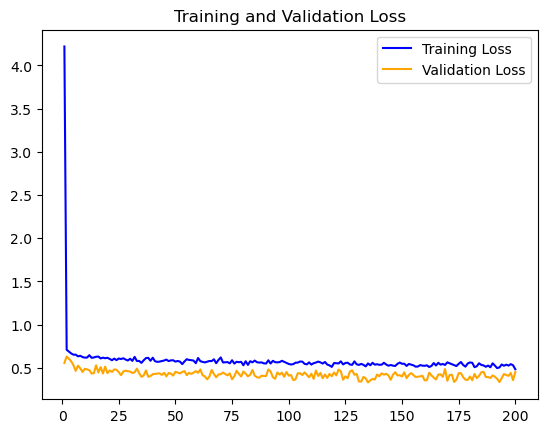

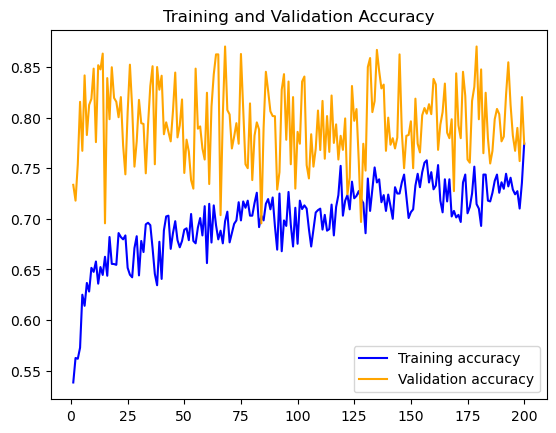

In [33]:
plot_loss(range(1, len(loss)+1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [28]:
y_pred = model.predict(test_flow)
y_test = test_flow.classes

29/29 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step


In [29]:
print(y_pred)

[[0.6184771 ]
 [0.14414495]
 [0.00294129]
 ...
 [0.9431092 ]
 [0.214667  ]
 [0.328211  ]]
